<a href="https://colab.research.google.com/github/quantbrasil/youtube/blob/master/src/004_Linear_Regression_with_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression with Stock Data

In this notebook, we'll explore the basics of linear regression using stock market data. Linear regression is one of the simplest and most powerful tools in a data scientist's toolkit, making it a perfect starting point for beginners.

We'll cover:
1. Getting stock data using Yahoo Finance
2. Visualizing relationships with scatter plots
3. Understanding linear regression intuitively
4. Implementing a simple linear regression model
5. Interpreting the results


In [4]:
%%capture
%pip install yfinance==0.2.54 matplotlib numpy pandas scikit-learn seaborn

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Set the style for our plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Getting Stock Data

Let's start by downloading some stock data. We'll use two Brazilian stocks: Petrobras (PETR4) and Itaú Unibanco (ITUB4) for the last 2 years. We'll use the Ticker object approach which is the recommended way to interact with yfinance.

In [97]:
period = "2y"

# Create Ticker objects
petr4_ticker = yf.Ticker('PETR4.SA')
itub4_ticker = yf.Ticker('ITUB4.SA')

# Get historical data using the history method
petr4 = petr4_ticker.history(period=period)
itub4 = itub4_ticker.history(period=period)

# Look at the PETR4 data
petr4.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-27 00:00:00-03:00,16.298765,16.866446,16.279841,16.494299,76250600,0.0,0.0
2023-02-28 00:00:00-03:00,16.532143,16.979981,15.920309,15.920309,130248100,0.0,0.0
2023-03-01 00:00:00-03:00,15.964463,16.040155,15.258016,15.958156,109257700,0.0,0.0
2023-03-02 00:00:00-03:00,16.033850,16.191539,15.371555,15.541859,124516200,0.0,0.0
2023-03-03 00:00:00-03:00,15.661701,16.235690,15.422014,16.210461,87591800,0.0,0.0


Let's also check the available columns in our dataframe to confirm the structure:

In [98]:
print("Available columns in PETR4 dataframe:")
print(petr4.columns)

Available columns in PETR4 dataframe:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')


Now, let's prepare our data for analysis. We'll focus on the Close prices and calculate daily returns for both stocks.

In [99]:
# Create a new dataframe with just the closing prices
stocks_data = pd.DataFrame({
    'PETR4': petr4['Close'],
    'ITUB4': itub4['Close']
})

# Calculate daily returns (percentage change)
returns_data = stocks_data.pct_change().dropna()

# Show the first few rows of both dataframes
print("Closing Prices:")
print(stocks_data.head())
print("\nDaily Returns:")
print(returns_data.head())

Closing Prices:
                               PETR4      ITUB4
Date                                           
2023-02-27 00:00:00-03:00  16.494299  21.530701
2023-02-28 00:00:00-03:00  15.920309  21.607176
2023-03-01 00:00:00-03:00  15.958156  21.256567
2023-03-02 00:00:00-03:00  15.541859  20.559355
2023-03-03 00:00:00-03:00  16.210461  20.584858

Daily Returns:
                              PETR4     ITUB4
Date                                         
2023-02-28 00:00:00-03:00 -0.034799  0.003552
2023-03-01 00:00:00-03:00  0.002377 -0.016226
2023-03-02 00:00:00-03:00 -0.026087 -0.032800
2023-03-03 00:00:00-03:00  0.043019  0.001240
2023-03-06 00:00:00-03:00  0.010117  0.022718


## 2. Visualizing Relationships with Scatter Plots

Before we dive into linear regression, let's visualize the relationship between our two stocks using a scatter plot. This helps us understand if there might be a linear relationship worth modeling.

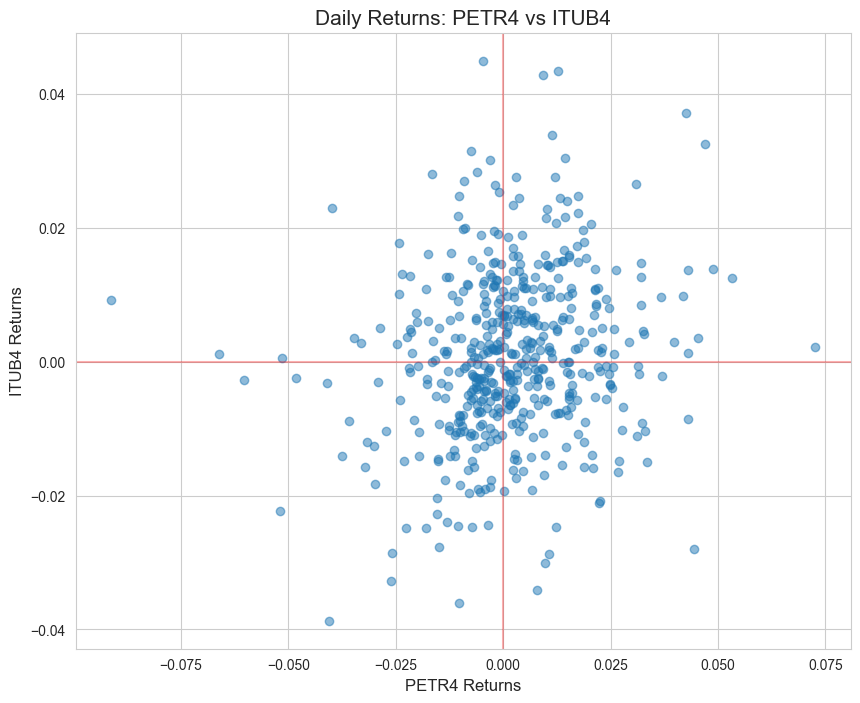

In [100]:
plt.figure(figsize=(10, 8))
plt.scatter(returns_data['PETR4'], returns_data['ITUB4'], alpha=0.5)
plt.title('Daily Returns: PETR4 vs ITUB4', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
plt.grid(True)
plt.show()

### Understanding Scatter Plots

The scatter plot above shows each day as a point, with:
- The x-axis representing PETR4's daily return
- The y-axis representing ITUB4's daily return

If there's a positive relationship between the stocks, we'd expect to see points forming a pattern from bottom-left to top-right. This would mean that when PETR4 goes up, ITUB4 tends to go up as well.

Let's also look at their price movements over time:

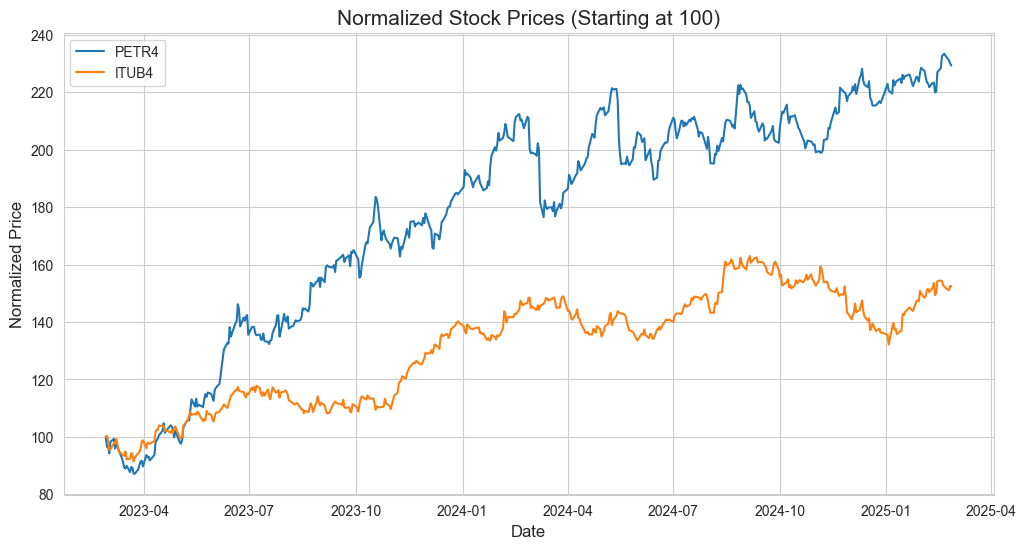

In [101]:
# Normalize prices to start at 100 for easier comparison
normalized_prices = stocks_data / stocks_data.iloc[0] * 100

plt.figure(figsize=(12, 6))
plt.plot(normalized_prices.index, normalized_prices['PETR4'], label='PETR4')
plt.plot(normalized_prices.index, normalized_prices['ITUB4'], label='ITUB4')
plt.title('Normalized Stock Prices (Starting at 100)', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 3. Understanding Linear Regression Intuitively

Linear regression is about finding the "best-fitting" straight line through a set of points. This line is often called the "line of best fit" or "regression line."

### The Intuition:

Imagine you have scattered points on a graph (like our returns scatter plot above). The goal of linear regression is to draw a straight line that is as close as possible to all these points.

The equation of this line is typically written as:

$$y = mx + b$$

Where:
- $y$ is the dependent variable (what we're trying to predict, in our case ITUB4 returns)
- $x$ is the independent variable (what we're using to make predictions, in our case PETR4 returns)
- $m$ is the slope (how much $y$ changes when $x$ increases by 1)
- $b$ is the y-intercept (the value of $y$ when $x = 0$)

In the context of stocks:
- If $m > 0$: The stocks tend to move in the same direction (positive correlation)
- If $m < 0$: The stocks tend to move in opposite directions (negative correlation)
- The magnitude of $m$ tells us how strongly one stock's return affects the other

Let's implement a simple linear regression model to see this in practice.

In [102]:
# Prepare the data for regression
X = returns_data['PETR4'].values.reshape(-1, 1)  # Independent variable (reshape for scikit-learn)
y = returns_data['ITUB4'].values  # Dependent variable

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient (slope) and intercept
best_slope = model.coef_[0]
best_intercept = model.intercept_

print(f"Linear Regression Equation: ITUB4_return = {best_slope:.4f} × PETR4_return + {best_intercept:.4f}")

Linear Regression Equation: ITUB4_return = 0.1291 × PETR4_return + 0.0007


Now, let's visualize our regression line on top of the scatter plot to see how well it fits the data:

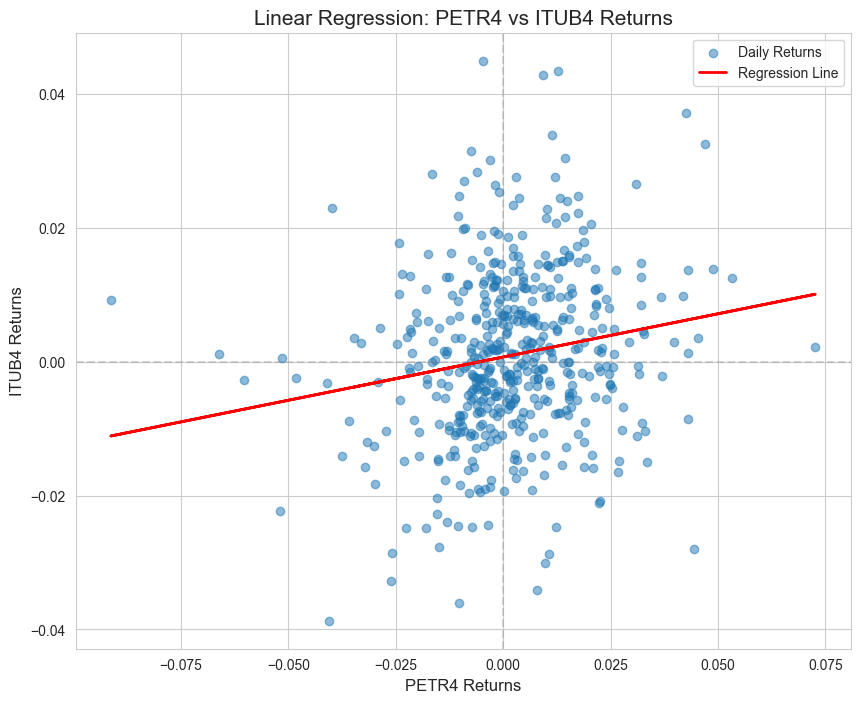

In [103]:
# Make predictions using our model
y_pred = model.predict(X)

# Create the scatter plot with regression line
plt.figure(figsize=(10, 8))

# Plot the actual data points
plt.scatter(X, y, alpha=0.5, label='Daily Returns')

# Plot the regression line
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')

plt.title('Linear Regression: PETR4 vs ITUB4 Returns', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

## 3.5 Building Intuition: How Linear Regression Finds the "Best Line"

When we have scattered data points (like our stock returns), there are infinitely many possible lines we could draw through them. How do we find the "best" one?

Let's visualize some potential regression lines with different slopes and intercepts.

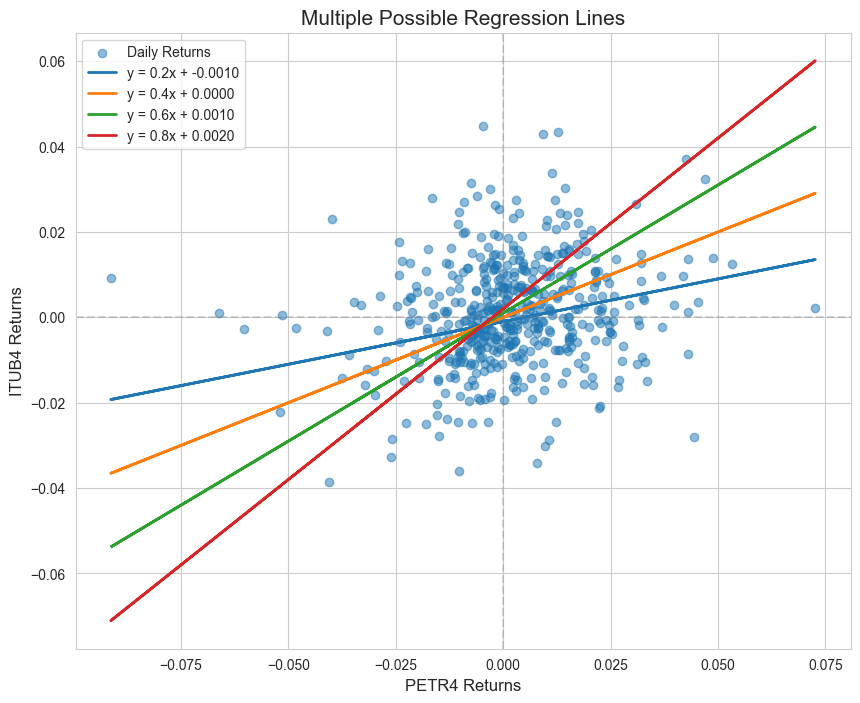

In [104]:
# Plot several possible regression lines
plt.figure(figsize=(10, 8))

# Plot the actual data points
plt.scatter(X, y, alpha=0.5, label='Daily Returns')

# Plot several possible regression lines
slopes = [0.2, 0.4, 0.6, 0.8]
intercepts = [-0.001, 0, 0.001, 0.002]

for s, i in zip(slopes, intercepts):
    y_line = s * X.flatten() + i
    plt.plot(X, y_line, linewidth=2, 
             label=f'y = {s:.1f}x + {i:.4f}')

plt.title('Multiple Possible Regression Lines', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### Understanding Residuals: The Key to Finding the Best Line

A "residual" is the difference between an actual value and the value predicted by our model. Visually, it's the vertical distance between a data point and the regression line.

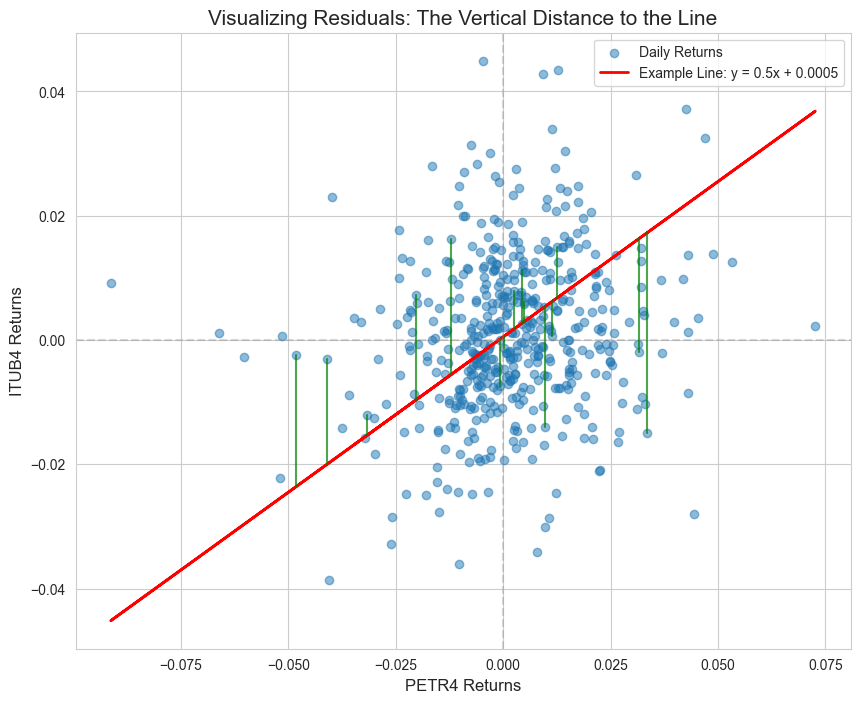

In [105]:
# Let's visualize residuals for a single possible regression line
plt.figure(figsize=(10, 8))

# Choose one possible line (not necessarily the best one)
example_slope = 0.5
example_intercept = 0.0005

# Calculate predictions with this line
example_predictions = example_slope * X.flatten() + example_intercept

# Plot the data and the line
plt.scatter(X, y, alpha=0.5, label='Daily Returns')
plt.plot(X, example_predictions, color='red', linewidth=2, 
         label=f'Example Line: y = {example_slope:.1f}x + {example_intercept:.4f}')

# Plot some residuals as vertical lines
indices = np.random.choice(len(X), 15, replace=False)  # Select random points
for i in indices:
    x_val = X[i][0]
    actual = y[i]
    predicted = example_slope * x_val + example_intercept
    residual = actual - predicted
    
    # Draw the vertical line representing the residual
    plt.plot([x_val, x_val], [predicted, actual], 'g-', alpha=0.7)

plt.title('Visualizing Residuals: The Vertical Distance to the Line', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### The Ordinary Least Squares (OLS) Method: Minimizing the Sum of Squared Residuals

Linear regression finds the line that minimizes the sum of squared residuals. Why squares? Because:
- Squaring makes all values positive (avoiding positive and negative errors canceling out)
- Squaring penalizes larger errors more heavily
- It has nice mathematical properties that make finding the minimum easier

Let's visualize how different lines have different total squared errors:

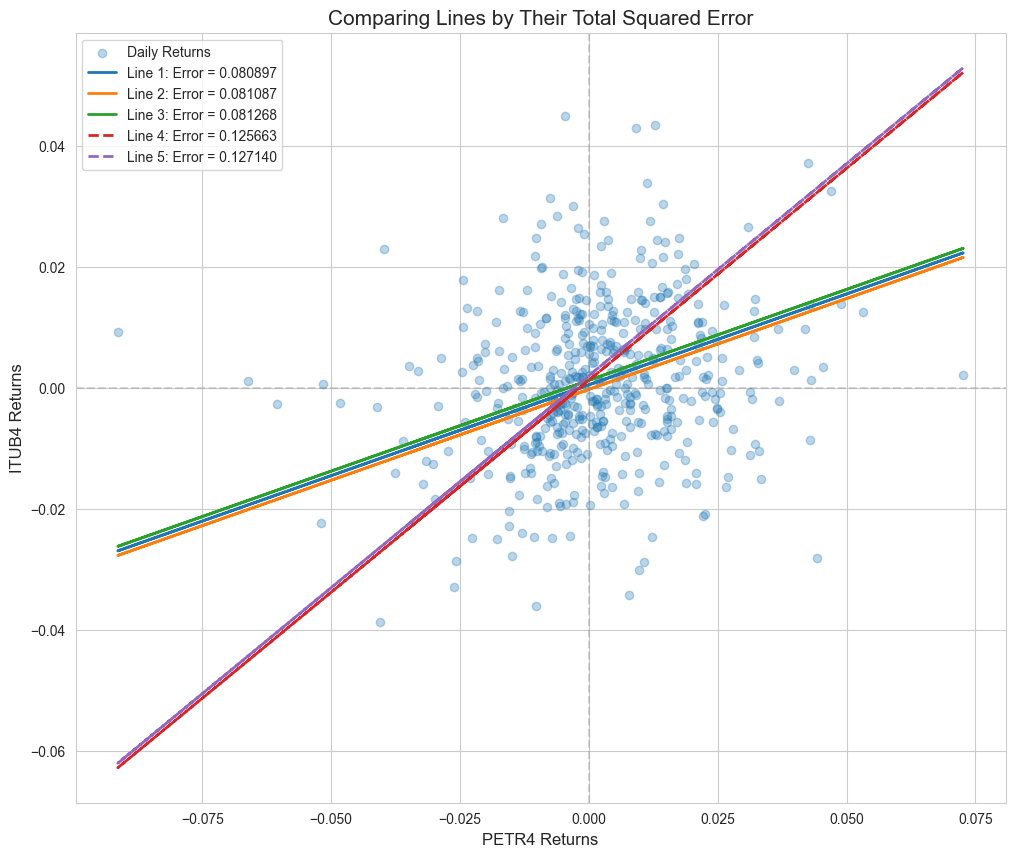

In [106]:
# Function to calculate total squared error for a given line
def calculate_squared_error(slope, intercept, X, y):
    predictions = slope * X + intercept
    residuals = y - predictions
    squared_residuals = residuals ** 2
    return np.sum(squared_residuals)

# Create a grid of potential slopes and intercepts
test_slopes = np.linspace(0.3, 0.7, 5)
test_intercepts = np.linspace(-0.001, 0.002, 5)
total_errors = []

# Plot to compare a few different lines and their total errors
plt.figure(figsize=(12, 10))

for slope in test_slopes:
    for intercept in test_intercepts:
        # Calculate total squared error
        total_error = calculate_squared_error(slope, intercept, X.flatten(), y)
        total_errors.append((slope, intercept, total_error))

# Sort by error and select a few to visualize
sorted_errors = sorted(total_errors, key=lambda x: x[2])

# Plot the top 3 (best) and bottom 2 (worst) lines
plt.scatter(X, y, alpha=0.3, label='Daily Returns')

# Plot best lines
for i, (slope, intercept, error) in enumerate(sorted_errors[:3]):
    predictions = slope * X + intercept
    plt.plot(X, predictions, linewidth=2, 
             label=f'Line {i+1}: Error = {error:.6f}')

# Plot worst lines
for i, (slope, intercept, error) in enumerate(sorted_errors[-2:]):
    predictions = slope * X + intercept
    plt.plot(X, predictions, linewidth=2, linestyle='--',
             label=f'Line {i+4}: Error = {error:.6f}')

plt.title('Comparing Lines by Their Total Squared Error', fontsize=15)
plt.xlabel('PETR4 Returns', fontsize=12)
plt.ylabel('ITUB4 Returns', fontsize=12)
plt.axhline(y=0, color='grey', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.3)
plt.grid(True)
plt.legend()
plt.show()

### The Mathematics of Linear Regression

When we call `model.fit()` in scikit-learn, it's solving for the slope (β₁) and intercept (β₀) using these formulas:

$$
\beta_1 = \frac{\sum[(x_i - \bar{x})(y_i - \bar{y})]}{\sum[(x_i - \bar{x})^2]}
$$

$$
\beta_0 = \bar{y} - \beta_1 \cdot \bar{x}
$$

Where:
- $x_i$ and $y_i$ are individual data points
- $\bar{x}$ and $\bar{y}$ are the means of x and y

Let's calculate these manually to confirm our understanding:

In [107]:
# Calculate slope and intercept manually
x_data = X.flatten()
y_data = y

x_mean = np.mean(x_data)
y_mean = np.mean(y_data)

# Calculate numerator: sum of (x_i - x_mean) * (y_i - y_mean)
numerator = np.sum((x_data - x_mean) * (y_data - y_mean))

# Calculate denominator: sum of (x_i - x_mean)²
denominator = np.sum((x_data - x_mean) ** 2)

# Calculate slope and intercept
manual_slope = numerator / denominator
manual_intercept = y_mean - manual_slope * x_mean

print(f"Manually calculated slope: {manual_slope:.4f}")
print(f"Manually calculated intercept: {manual_intercept:.4f}")
print(f"scikit-learn calculated slope: {best_slope:.4f}")
print(f"scikit-learn calculated intercept: {best_intercept:.4f}")

Manually calculated slope: 0.1291
Manually calculated intercept: 0.0007
scikit-learn calculated slope: 0.1291
scikit-learn calculated intercept: 0.0007


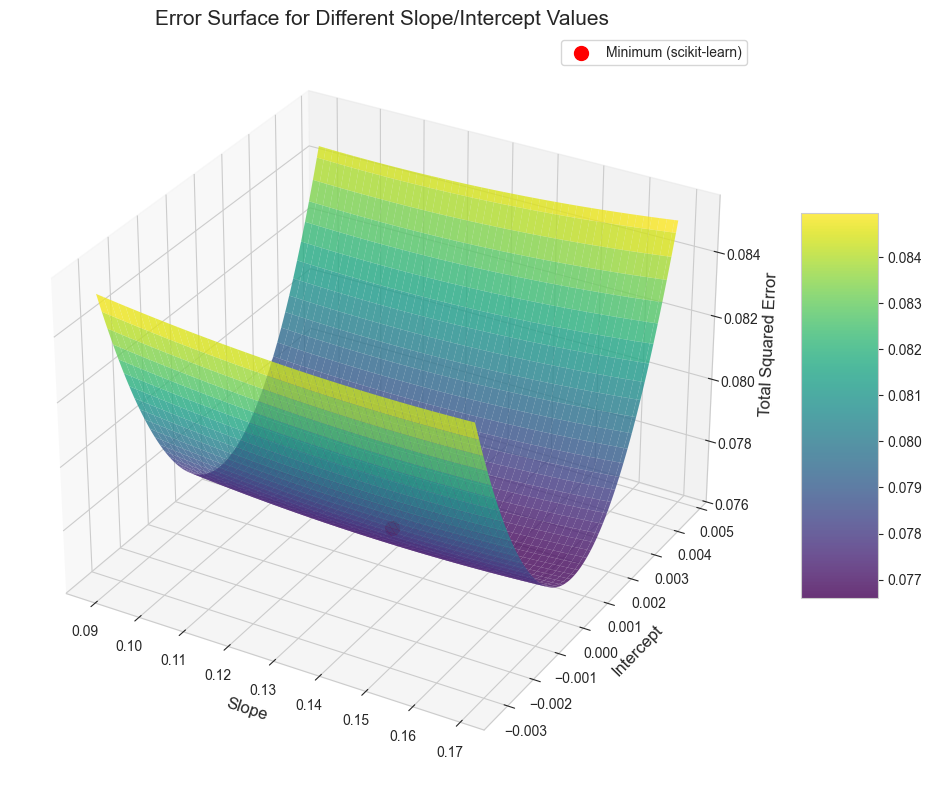

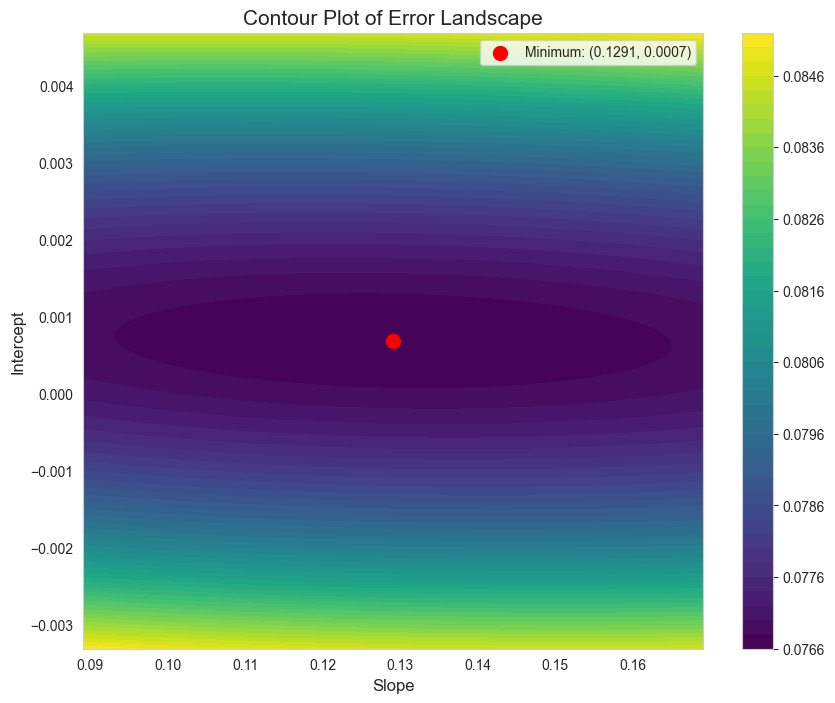

Error at scikit-learn solution (slope=0.1291, intercept=0.0007): 0.0766088961
This should be the minimum error value on the surface


In [108]:
# Create a fine grid of slope and intercept values around our solution
# to create an error surface
margin = 0.04  # Explore around the solution
num_points = 100  # More points for a smoother surface

# Create a grid centered around the scikit-learn solution
fine_slopes = np.linspace(best_slope - margin, best_slope + margin, num_points)
fine_intercepts = np.linspace(best_intercept - margin/10, best_intercept + margin/10, num_points)

# Calculate error for each point in the grid
error_grid = np.zeros((len(fine_slopes), len(fine_intercepts)))

for i, slope in enumerate(fine_slopes):
    for j, intercept in enumerate(fine_intercepts):
        error_grid[i, j] = calculate_squared_error(slope, intercept, X.flatten(), y)

# Create a meshgrid for plotting
slope_grid, intercept_grid = np.meshgrid(fine_slopes, fine_intercepts)

# Plot a 3D surface of the error landscape
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the error surface
surf = ax.plot_surface(slope_grid, intercept_grid, error_grid.T, 
                      cmap='viridis', alpha=0.8, edgecolor='none')

# Mark the minimum point (scikit-learn solution)
ax.scatter([best_slope], [best_intercept], 
           [calculate_squared_error(best_slope, best_intercept, X.flatten(), y)],
           color='red', s=100, label='Minimum (scikit-learn)')

# Calculate the error at our solution
min_error = calculate_squared_error(best_slope, best_intercept, X.flatten(), y)

ax.set_xlabel('Slope', fontsize=12)
ax.set_ylabel('Intercept', fontsize=12)
ax.set_zlabel('Total Squared Error', fontsize=12)
ax.set_title('Error Surface for Different Slope/Intercept Values', fontsize=15)

# Add a colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
plt.legend()
plt.show()

# Also create a contour plot for a clearer top-down view
plt.figure(figsize=(10, 8))
contour = plt.contourf(slope_grid, intercept_grid, error_grid.T, 50, cmap='viridis')
plt.colorbar(contour)

# Mark the minimum
plt.scatter([best_slope], [best_intercept], color='red', s=100, 
            label=f'Minimum: ({best_slope:.4f}, {best_intercept:.4f})')

plt.title('Contour Plot of Error Landscape', fontsize=15)
plt.xlabel('Slope', fontsize=12)
plt.ylabel('Intercept', fontsize=12)
plt.legend()
plt.show()

print(f"Error at scikit-learn solution (slope={best_slope:.4f}, intercept={best_intercept:.4f}): {min_error:.10f}")
print("This should be the minimum error value on the surface")

## 4. Evaluating Our Model

Now that we have built our linear regression model, let's evaluate how well it performs. There are several metrics we can use:

1. **R-squared (R²)**: Measures the proportion of variance in the dependent variable that's explained by the independent variable(s).
   - R² ranges from 0 to 1, where higher is better
   - R² = 1 means the model explains all the variability
   - R² = 0 means the model explains none of the variability

2. **Mean Squared Error (MSE)**: Measures the average squared difference between the predicted values and actual values.
   - Lower MSE values indicate better fit

Let's calculate these metrics for our model:

In [109]:
# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)

print(f"R-squared (R²): {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:.8f}")

R-squared (R²): 0.0309
Mean Squared Error (MSE): 0.00015322


### Interpreting the Results

Let's interpret what our model is telling us:

1. **The Slope**: The coefficient (slope) tells us how much ITUB4's return changes when PETR4's return increases by 1%. 

2. **The Intercept**: This represents the expected return of ITUB4 when PETR4's return is 0%.

3. **R-squared**: This tells us what percentage of the variation in ITUB4's returns can be explained by PETR4's returns.

What does this mean for investors?
- If there's a strong relationship (high R²), one stock could potentially be used to predict the other
- The slope gives us an idea of the "beta" or sensitivity of one stock to the other
- A low R² suggests other factors are more important in determining the stock's movements

## 5. A Real-World Example: Predicting One Stock with Another

Let's try using our model to "predict" ITUB4's returns based on PETR4's returns. We'll split our data into training and testing sets to simulate a real-world scenario.

In [110]:
# Split data into training (80%) and testing (20%)
train_size = int(len(returns_data) * 0.8)
train_data = returns_data.iloc[:train_size]
test_data = returns_data.iloc[train_size:]

# Prepare training data
X_train = train_data['PETR4'].values.reshape(-1, 1)
y_train = train_data['ITUB4'].values

# Prepare testing data
X_test = test_data['PETR4'].values.reshape(-1, 1)
y_test = test_data['ITUB4'].values

# Train the model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate the model
test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test Set R-squared: {test_r2:.4f}")
print(f"Test Set MSE: {test_mse:.8f}")

Test Set R-squared: 0.0359
Test Set MSE: 0.00018621


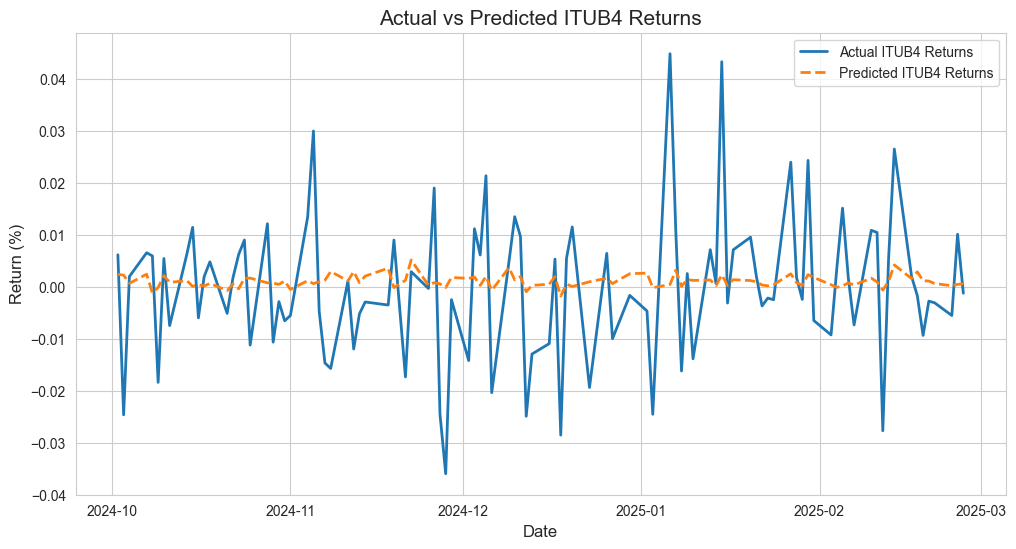

In [111]:
# Let's visualize our predictions vs. actual values
plt.figure(figsize=(12, 6))

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test,
    'Predicted': y_pred.flatten()
}).set_index('Date')

# Plot actual vs predicted values
plt.plot(results.index, results['Actual'], label='Actual ITUB4 Returns', linewidth=2)
plt.plot(results.index, results['Predicted'], label='Predicted ITUB4 Returns', linewidth=2, linestyle='--')

plt.title('Actual vs Predicted ITUB4 Returns', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 6. Going Further: Multiple Linear Regression

So far, we've used only one stock to predict another. In reality, a stock's movement is influenced by multiple factors. We can extend our simple linear regression to include multiple variables - this is called multiple linear regression.

Let's add a market index (Ibovespa) to our model to see if it improves our predictions.

In [112]:
# Download Ibovespa data using Ticker object
ibov_ticker = yf.Ticker('^BVSP')
ibov = ibov_ticker.history(period=period)

# Add Ibovespa to our dataset
stocks_data['IBOV'] = ibov['Close']
returns_data = stocks_data.pct_change().dropna()

# Split data again
train_size = int(len(returns_data) * 0.8)
train_data = returns_data.iloc[:train_size]
test_data = returns_data.iloc[train_size:]

# Prepare training data with multiple features
X_train_multi = train_data[['PETR4', 'IBOV']].values
y_train = train_data['ITUB4'].values

# Prepare testing data
X_test_multi = test_data[['PETR4', 'IBOV']].values
y_test = test_data['ITUB4'].values

# Train the multiple regression model
multi_model = LinearRegression()
multi_model.fit(X_train_multi, y_train)

# Make predictions
y_pred_multi = multi_model.predict(X_test_multi)

# Evaluate the model
multi_r2 = r2_score(y_test, y_pred_multi)
multi_mse = mean_squared_error(y_test, y_pred_multi)

print(f"Multiple Regression Coefficients:")
print(f"PETR4: {multi_model.coef_[0]:.4f}")
print(f"IBOV: {multi_model.coef_[1]:.4f}")
print(f"Intercept: {multi_model.intercept_:.4f}")
print(f"\nTest Set R-squared: {multi_r2:.4f} (vs. {test_r2:.4f} for simple regression)")
print(f"Test Set MSE: {multi_mse:.8f} (vs. {test_mse:.8f} for simple regression)")

Multiple Regression Coefficients:
PETR4: -0.1276
IBOV: 1.0524
Intercept: 0.0008

Test Set R-squared: 0.7203 (vs. 0.0359 for simple regression)
Test Set MSE: 0.00005403 (vs. 0.00018621 for simple regression)


### Comparing the Models

Let's visualize how our multiple regression model compares to our simple regression model:

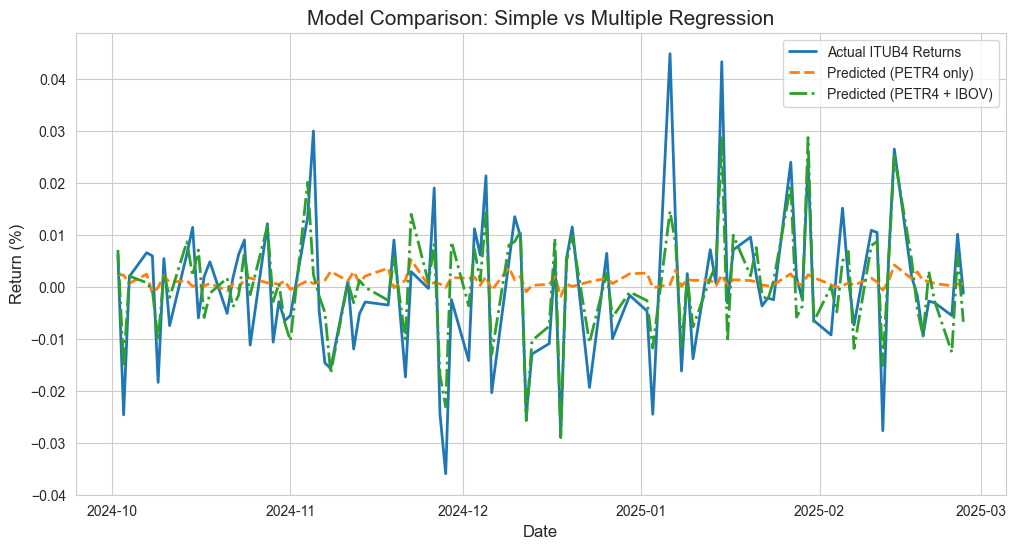

In [113]:
# Create a DataFrame with actual and both sets of predicted values
comparison = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test,
    'Simple Model': y_pred.flatten(),
    'Multiple Model': y_pred_multi.flatten()
}).set_index('Date')

plt.figure(figsize=(12, 6))
plt.plot(comparison.index, comparison['Actual'], label='Actual ITUB4 Returns', linewidth=2)
plt.plot(comparison.index, comparison['Simple Model'], label='Predicted (PETR4 only)', linewidth=2, linestyle='--')
plt.plot(comparison.index, comparison['Multiple Model'], label='Predicted (PETR4 + IBOV)', linewidth=2, linestyle='-.')

plt.title('Model Comparison: Simple vs Multiple Regression', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Return (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## 7. Conclusion

In this notebook, we've explored linear regression with stock data, starting from the basics:

1. We visualized relationships between stocks using scatter plots
2. We built a simple linear regression model to predict one stock's returns based on another
3. We evaluated our model using metrics like R-squared and MSE
4. We extended our approach to multiple linear regression by adding a market index

### Key Takeaways:

- Linear regression helps us quantify relationships between variables
- The slope tells us how sensitive one stock is to changes in another
- R-squared tells us how much of the variation is explained by our model
- Adding more relevant variables can improve our predictions

### Limitations and Next Steps:

- Linear regression assumes a linear relationship, which isn't always true in financial markets
- Financial time series often have special properties (like autocorrelation) that simple linear regression doesn't account for
- For more robust models, we might need to consider:
  - Time series analysis techniques
  - More sophisticated machine learning models
  - Additional features like technical indicators or economic data

Linear regression is a powerful starting point for quantitative analysis, but it's just the beginning of what's possible with data science and finance!